In [1]:
from misc_functions import *
import h5py
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import random
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.interpolate import RegularGridInterpolator
import shutil

ImportError: DLL load failed while importing _errors: Die angegebene Prozedur wurde nicht gefunden.

In [2]:
def interpolate_spectrum(sf, emis_ang, topo, detector_num, interp_func, spicav_wavelength, disort_wavenum):
    sf = sf[0] if isinstance(sf, (list, np.ndarray)) else sf

    STEP = disort_wavenum[1] - disort_wavenum[0]

    interp_disort_spectrum = interp_func([sf, topo, emis_ang])[0]

    conv_disort_spectrum = conv_spicavir_matrix_sw_lw(interp_disort_spectrum, 
                                                     STEP, 
                                                     CONV_PATH, 
                                                     'SW', 
                                                     1, 
                                                     detector_num)

    conv_spectrum_wavelength_lattice = conv_disort_spectrum * disort_wavenum**2 / 1e4
    disort_wavelength = 1e4 / disort_wavenum
    
    final_lambda_lattice, final_disort_spectrum, spicav_mask =\
        integrate_model_on_data_lattice(spicav_wavelength,
                                        disort_wavelength,
                                        conv_spectrum_wavelength_lattice)
    
    return final_lambda_lattice, final_disort_spectrum, spicav_mask

# Функция потерь для оптимизации (например, среднеквадратичная ошибка)
def loss_function(sf, emis_ang, topo, detector_num, interp_func, spicav_spectrum, spicav_wavelength, disort_wavenum):

    final_lambda_lattice, final_disort_spectrum, spicav_mask =\
        interpolate_spectrum(sf, emis_ang, topo, detector_num, interp_func, spicav_wavelength, disort_wavenum)

    opt_cutoff = int(2*len(final_disort_spectrum)/3)

    loss_metric = np.mean((final_disort_spectrum - spicav_spectrum[::-1][spicav_mask]) ** 2)
    # loss_metric = np.mean((final_disort_spectrum[opt_cutoff:] - spicav_spectrum[::-1][spicav_mask][opt_cutoff:]) ** 2)
    
    return loss_metric

In [3]:
INPUT_PATH = 'input/'
DATA_PATH = 'SPICAV-IR Data Sort/SPICAV_1micron/'
FILTERED_DATA_FILE = 'SPICAV-IR Data Sort/filtered_results3.h5'
# DISORT_OUTPUT_PATH = 'disort_output/CO2_hot_ames_H2O_HDO_hitran_005_9600_11000/'

DISORT_OUTPUT_PATH = 'disort_output/'
# DISORT_TABLE_FILE = 'disort_table_CO2_hot_ames_bezard_H2O_HDO_hitran_foreign_cont_005_9600_11000_104.h5'
DISORT_TABLE_FILE = 'disort_table_bezard.h5'

CONV_PATH = 'conv/'

TOPO_FILE = 'TOPOGRD.DAT'

GAS_EXT_PATH = 'gas_ext/'
# GAS_EXT_FILE = 'gas_ext_CO2_hot_ames_bezard_H2O_HDO_hitran_foreign_cont_005_9600_11000_104.csv'
GAS_EXT_FILE = 'gas_ext_CO2_hot_ames_H2O_HDO_hitran_bezard_005_9600_11000_104.csv'

CORE_NAME = GAS_EXT_FILE[8:-4]


IMAGE_VAR = 'v1'
IMAGE_FOLDER = f'images/{CORE_NAME}_{IMAGE_VAR}/'

In [4]:
IMAGE_FOLDER

'images/CO2_hot_ames_H2O_HDO_hitran_bezard_005_9600_11000_104_v1/'

In [5]:
dat = np.loadtxt(INPUT_PATH + TOPO_FILE)
ddd = dat.flatten()

lat_topo = np.arange(89.5, -90, -1)
lon_topo = np.arange(240.5-360, 239.5)

topo_map = np.zeros((180, 360))
for ii in range(180):
    topo_map[ii, :] = ddd[ii * 360:(ii + 1) * 360]

lon_topo[lon_topo < 0] += 360
ind = np.argsort(lon_topo)
lon_topo = lon_topo[ind]
topo_map = topo_map[:, ind]

In [6]:
with h5py.File(DISORT_OUTPUT_PATH + DISORT_TABLE_FILE, 'r') as f:
# with h5py.File('disort_output/test111', 'r') as f:
    sf_grid = f['sf'][:]  # значения x1
    topo_grid = f['topo'][:]  # значения x2
    emis_ang_grid = f['emis_ang'][:]  # значения x3
    spectra = f['spectra'][:]  # многомерный массив спектров

interp_disort = RegularGridInterpolator((sf_grid , topo_grid, emis_ang_grid), spectra)

In [7]:
spectra.shape

(6, 14, 3, 28001)

In [8]:
sf_grid

array([2.4, 2. , 1.6, 1.2, 0.8, 0.4])

In [9]:
topo_grid

array([-3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [10]:
emis_ang_grid

array([ 0, 10, 20])

In [11]:
interp_disort([0.4+1e-4, 0.03781973333333335, 0.07])[0]

array([2.59310174e-09, 1.14620579e-09, 2.69713166e-10, ...,
       5.23808149e-07, 5.22784885e-07, 5.20183456e-07])

In [12]:
gas_abs_data = pd.read_csv(GAS_EXT_PATH + GAS_EXT_FILE, header=None)
disort_wavenum = np.array(gas_abs_data)[0]

9333


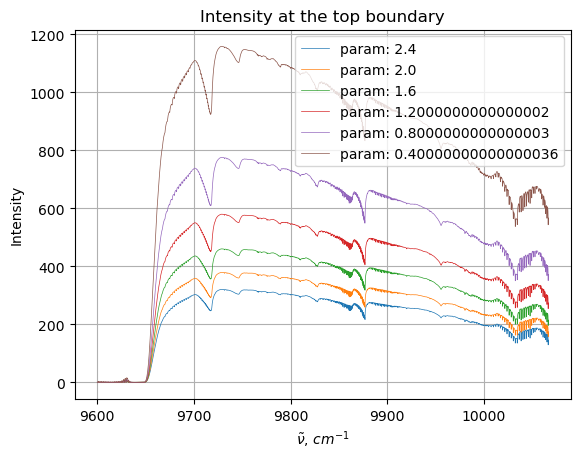

In [13]:
opt_cutoff = int(spectra.shape[3]/3)
print(opt_cutoff)
plot_for_grid(spectra[:,3,0,:opt_cutoff] * disort_wavenum[:opt_cutoff]**2 / 1e4, disort_wavenum[:opt_cutoff], sf_grid)

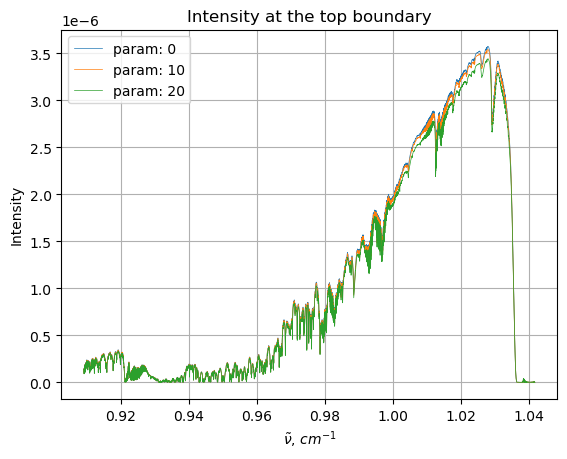

In [14]:
plot_for_grid(spectra[0,3,:] * disort_wavenum**2 / 1e4, 1e4 / disort_wavenum, emis_ang_grid)

In [15]:
# final_lambda_lattice, final_disort_spectrum, spicav_mask =\
#     interpolate_spectrum(1, 0, 0, 1, interp_disort, valid_wavelength, disort_wavenum)

# plt.plot(
#         final_lambda_lattice[int(len(final_disort_spectrum)/2):], 
#         final_disort_spectrum[int(len(final_disort_spectrum)/2):], 
#         color='r'
#         )

# plt.show()

In [16]:
# def find_nearest(array, value):
#     idx = np.searchsorted(-array, -value, side='left')
#     if idx > 0 and (idx == len(array) or abs(value - array[idx-1]) < abs(value - array[idx])):
#         return idx-1
#     else:
#         return idx

In [17]:
mat_files = os.listdir(DATA_PATH)
hdf5_file = h5py.File(FILTERED_DATA_FILE, 'r')

# Для 1_micron_data.csv
session_ = []
filename_ = []
detector_ = []

lat_, lon_, fov_ = [], [], []

# Сюда попадут спетры с фильтрацией выбросов
valid_intensities_all, valid_wavelengths_all = [], []

lt_result, sza_result, date_result = [], [], []

sf_ = []
emis_ = []
height_ = []
# Старт парсинга
for filename in list(hdf5_file.keys()):
    if filename.endswith('A.mat'):
      continue

    mat_data = loadmat(DATA_PATH + filename)
    file_group = hdf5_file[filename]
    for session in file_group.keys():
        session_group = file_group[session]
        session_num = int(session)
        for detector in session_group.keys():
            detector_group = session_group[detector]
            detector_num = int(detector)

            wl_all = mat_data['DATA'][f'wl{detector_num}'][0][0][:, 0]
            det_all = mat_data['DATA'][f'det{detector_num}'][0][0].T[session_num]
            
            cutoff_pos_window = find_nearest(wl_all, 1.05)
            cuton_pos_window = find_nearest(wl_all, 0.9)
    
            wl_ = wl_all[cutoff_pos_window:cuton_pos_window]
            det_ = det_all[cutoff_pos_window:cuton_pos_window]

            lat = mat_data['GEOM']['Lat'][0][0][0][session_num]
            lon = mat_data['GEOM']['Lon'][0][0][0][session_num]

            lat_index = (np.abs(lat_topo - lat)).argmin()
            lon_index = (np.abs(lon_topo - lon)).argmin()

            height = topo_map[lat_index, lon_index]
            
            emis = mat_data['GEOM']['EMIS'][0][0][0][session_num]
            
            if emis < 0 or emis > 20: # фильтруем наблюдения с большим отклонением от надира
               continue

            fovlat_max = mat_data['GEOM']['FOVLAT'][0][0][session_num][0].max()
            fovlat_min = mat_data['GEOM']['FOVLAT'][0][0][session_num][0].min()
            fovlon_max = mat_data['GEOM']['FOVLON'][0][0][session_num][0].max()
            fovlon_min = mat_data['GEOM']['FOVLON'][0][0][session_num][0].min()
            
            fov = max(
                min(fovlat_max - fovlat_min, 180 - (fovlat_max - fovlat_min)), 
                min(fovlon_max - fovlon_min, 360 - (fovlon_max - fovlon_min))
            )
            
            mask = detector_group['mask'][:]#==1

            valid_intensity = det_[mask]

            nan_mask = ~np.isnan(valid_intensity)
            
            valid_intensity = valid_intensity[nan_mask]
            
            valid_wavelength = wl_[mask]
            valid_wavelength = valid_wavelength[nan_mask]
            
            # print(emis, height)
            
            result = minimize(loss_function, 
                              x0=1, 
                              args=(emis, height, detector_num, interp_disort, valid_intensity, valid_wavelength, disort_wavenum),
                              bounds=[(0.4+1e-4, 2.4-1e-4)]
                              )

            optimal_sf = result.x[0]

            lat_.append(lat)
            lon_.append(lon)
            fov_.append(fov)
            
            sf_.append(optimal_sf)
            emis_.append(emis)
            height_.append(height)
            detector_.append(detector_num)
            valid_intensities_all.append(valid_intensity)
            valid_wavelengths_all.append(valid_wavelength)
            

# Закрываем HDF5 файл после чтения всех данных
hdf5_file.close()

In [18]:
emis, height

(4.8826787555555535, 0.1)

In [19]:
filename, session, detector

('3086A02_N.mat', '9', '1')

In [20]:
fov_ = np.array(fov_)
lat_ = np.array(lat_)
lon_ = np.array(lon_)

(array([  3.,   5.,  36., 111., 256., 461., 241., 262., 212., 299.]),
 array([0.53694902, 0.72324412, 0.90953922, 1.09583431, 1.28212941,
        1.46842451, 1.65471961, 1.84101471, 2.0273098 , 2.2136049 ,
        2.3999    ]),
 <BarContainer object of 10 artists>)

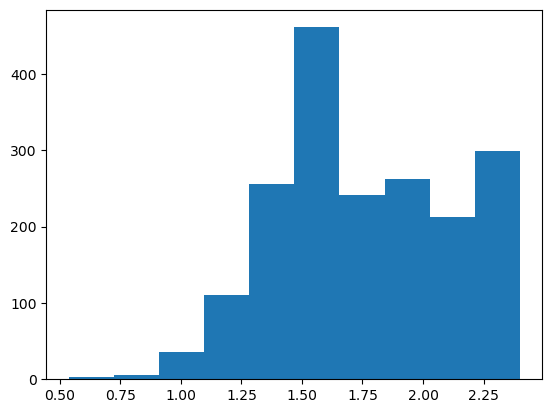

In [21]:
plt.hist(sf_)

In [22]:
os.makedirs(IMAGE_FOLDER, exist_ok=True)

for filename in os.listdir(IMAGE_FOLDER):
    file_path = os.path.join(IMAGE_FOLDER, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.remove(file_path)  # Удаление файла или ссылки
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Удаление каталога и его содержимого
    except Exception as e:
        print(f'Не удалось удалить {file_path}. Причина: {e}')

In [23]:
for i in range(len(sf_)):

    sf = sf_[i]
    emis_ang = emis_[i]
    topo = height_[i]
    detector_num = detector_[i]
    spicav_intensity = valid_intensities_all[i]
    spicav_wavelength = valid_wavelengths_all[i]

    final_lambda_lattice, final_disort_spectrum, spicav_mask =\
        interpolate_spectrum(sf, emis_ang, topo, detector_num, interp_disort, spicav_wavelength, disort_wavenum)

    SF = str(np.round(sf,2)).replace('.', '_')
    TOPO = str(np.round(topo,2)).replace('.', '_').replace('-', 'negative_')
    EMIS = str(np.round(emis_ang,2)).replace('.', '_')
    
    plt.plot(
            final_lambda_lattice,
            spicav_intensity[::-1][spicav_mask],
            color='b',
            # s=1.5,
            label='spicav'
            )

    plt.plot(
            final_lambda_lattice, 
            final_disort_spectrum, 
            color='r', 
            # s=1.5,
            label=f'model, sf={np.round(sf,2)}, topo={np.round(topo,2)}, emission angle={np.round(emis,2)}'
            )
    
    plt.legend()

    IMAGE_NAME = f'compare_spectra_{i}_sf_{SF}_topo_{TOPO}_emis_{EMIS}'
    
    plt.savefig(IMAGE_FOLDER + IMAGE_NAME)
    plt.close()

In [24]:
print(IMAGE_FOLDER + IMAGE_NAME)

images/CO2_hot_ames_H2O_HDO_hitran_bezard_005_9600_11000_104_v1/compare_spectra_1885_sf_2_4_topo_0_1_emis_4_88


In [25]:
min_height = topo_map.min()
max_height = topo_map.max()
width = max_height - min_height

levels=[]
N = 9

def f(x):
  return (x)**2

for i in range(N):
  levels.append(min_height + width*f(i)/f(N-1))

In [26]:
from matplotlib.collections import EllipseCollection
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize

In [27]:
max(1 - fov_/(max(fov_)+4))

1.0

In [28]:
alpha = 1 - fov_/(max(fov_)+4)

In [29]:
alpha = 1

In [30]:
fig, ax = plt.subplots(figsize=(18, 8))

csf = ax.contourf(lon_topo, lat_topo, topo_map, cmap='Greys', levels=levels);

cs = ax.contour(csf, linewidths=0.5, colors='k')

for level in cs.collections:
    for kp, path in reversed(list(enumerate(level.get_paths()))):
        verts = path.vertices
        diameter = np.max(verts.max(axis=0) - verts.min(axis=0))
        if diameter < 4.5:
            del(level.get_paths()[kp])

plt.gcf().canvas.draw()

offsets = list(zip(lon_, lat_))

norm = Normalize(vmin=min(sf_), vmax=max(sf_))
sm = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.jet) # cool


ec = EllipseCollection(fov_, fov_, angles=0, units='xy',
                                       facecolors=plt.cm.jet(norm(sf_)), # cool
                                       offsets=offsets, transOffset=ax.transData, alpha=alpha, linewidth=0)
ax.add_collection(ec)

ax.axis([lon_topo.min(), lon_topo.max(), lat_topo.min(), lat_topo.max()])
plt.xticks([10 + 85*i for i in range(5)])



cbar_int = plt.colorbar(sm, ax=ax, label='Cloud scaling factor', pad=-0.05)
cbar_int.outline.set_color('black')
cbar_int.outline.set_linewidth(0.4)
cbar_int.ax.tick_params(direction="in")

cbar_topo = plt.colorbar(csf, label='Altitude, $km$', spacing='proportional', ticks=levels[::2], format='{x:.2f}')
cbar_topo.outline.set_color('black')
cbar_topo.outline.set_linewidth(0.4)
cbar_topo.ax.tick_params(direction="in")

ax.set_aspect(1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Observations for wavelength of 1$\mu m$')
plt.show
plt.savefig(f'images/sf_on_map.png', dpi=800)
plt.close();

C:\Users\underhamster\AppData\Local\Temp\ipykernel_146652\925148318.py:7: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for level in cs.collections:
